- generate data from 
```
phi = c1 * (np.exp(beta * (I1 - 3.0)) - 1.0) + c2 * (I2 - 3.0) + g(I3)
```

Saved CSV -> C:\Users\qq528\OneDrive - KTH\WorkingFolder\Courses\FSM3001_data_driven\sindy_project\phi_dataset_eps_0.0_0.2_n100_beta_85.13.csv
Saved plot -> C:\Users\qq528\OneDrive - KTH\WorkingFolder\Courses\FSM3001_data_driven\sindy_project\phi_vs_epsilon.png


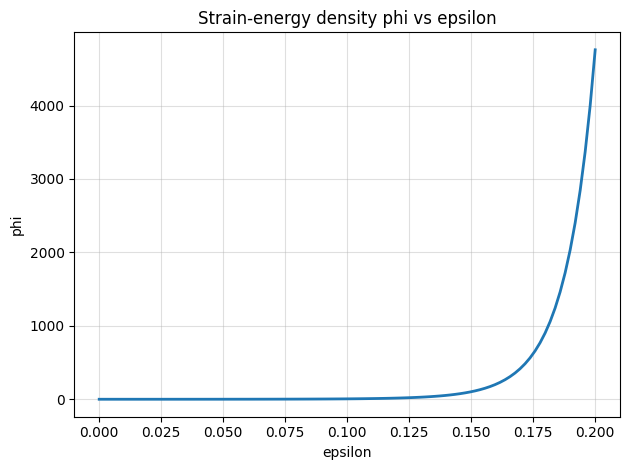

In [1]:
# generate_phi_dataset.py
# Compute phi = c1*(exp(beta*(I1-3)) - 1) + c2*(I2 - 3) + g(I3)
# with I1 = lambda^2 + 2/lambda, I2 = 2*lambda + 1/lambda^2, I3 = 1, lambda = epsilon + 1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---- Parameters ----
c1 = 0.542
c2 = 0.013
beta = 85.13          # tissue : Bovine
eps_min, eps_max = 0.0, 0.2
n_points = 100

# Volumetric term. With I3 = 1 constant, this becomes a constant shift; use 0 by default.
def g(I3):
    # Example alternative (commented): return 0.5 * k * (I3 - 1.0)**2
    return np.zeros_like(I3)

# ---- Generate epsilon and invariants ----
epsilon = np.linspace(eps_min, eps_max, n_points)  # 100 points from 0 to 0.2
lam = epsilon + 1.0
I1 = lam**2 + 2.0/lam
I2 = 2.0*lam + 1.0/(lam**2)
I3 = np.ones_like(lam)

# ---- Compute phi ----
phi = c1 * (np.exp(beta * (I1 - 3.0)) - 1.0) + c2 * (I2 - 3.0) + g(I3)

# ---- Save to CSV ----
df = pd.DataFrame({
    "epsilon": epsilon,
    "lambda": lam,
    "I1": I1,
    "I2": I2,
    "I3": I3,
    "phi": phi
})

out_dir = Path(".")
csv_path = out_dir / f"phi_dataset_eps_{eps_min}_{eps_max}_n{n_points}_beta_{beta}.csv"
df.to_csv(csv_path, index=False)
print(f"Saved CSV -> {csv_path.resolve()}")

# ---- Quick plot ----
plt.figure()
plt.plot(epsilon, phi, linewidth=2)
plt.xlabel("epsilon")
plt.ylabel("phi")
plt.title("Strain-energy density phi vs epsilon")
plt.grid(True, alpha=0.4)
plt.tight_layout()
png_path = out_dir / "phi_vs_epsilon.png"
plt.savefig(png_path, dpi=200)
print(f"Saved plot -> {png_path.resolve()}")
plt.show()


- Fit  data from 
```
phi = c1 * (np.exp(beta * (I1 - 3.0)) - 1.0) + c2 * (I2 - 3.0) + g(I3)
```
- Changing epsilon from 0 to 0.2, 100 data points

In [2]:
# fit_phi_with_pysindy_min.py
# Read the generated CSV and use PySINDy's STLSQ for sparse regression to get sparse expression of phi(eps).
# You only need to change CSV_PATH to your actual filename.

import numpy as np
import pandas as pd
import pysindy as ps

# ====== Path and Hyperparameters ======
CSV_PATH = "phi_dataset_eps_0.0_0.2_n100_beta_85.13.csv"  # <- Change to your actual filename
beta = 85.13                         # If your data uses different beta, change here
threshold = 1e-3               # Sparsity threshold, 1e-4 ~ 1e-2 adjustable
alpha = 0.0                    # STLSQ ridge parameter (0 means ordinary least squares)

# ====== Read CSV ======
df = pd.read_csv(CSV_PATH)
eps = df["epsilon"].to_numpy()
lam = df["lambda"].to_numpy()
I1  = df["I1"].to_numpy()
I2  = df["I2"].to_numpy()
I3  = df["I3"].to_numpy()
phi = df["phi"].to_numpy().reshape(-1, 1)

# ====== Build candidate feature library (corresponding to your theoretical structure) ======
# 1, (I1-3), (I2-3), exp(beta*(I1-3))-1, (I3-1)
feature_names = [
    "1",
    "(I1-3)",
    "(I2-3)",
    "exp(beta*(I1-3))-1",
    "(I3-1)",
]
Theta = np.column_stack([
    np.ones_like(I1),
    (I1 - 3.0),
    (I2 - 3.0),
    np.exp(beta * (I1 - 3.0)) - 1.0,
    (I3 - 1.0),
])

# ====== Use PySINDy's STLSQ for fitting (Note: don't pass fit_intercept) ======
opt = ps.STLSQ(threshold=threshold, alpha=alpha)
opt.fit(Theta, phi)                 # Directly fit y ≈ Theta @ w
coef = opt.coef_.reshape(-1)        # (n_features,)

# ====== Output sparse formula ======
def pretty_formula(names, c, tol=1e-12):
    terms = [f"({ci:.12g})*{ni}" for ni, ci in zip(names, c) if abs(ci) > tol]
    return "phi(epsilon) ≈ " + (" + ".join(terms) if terms else "0")

print("\n=== Discovered sparse formula ===")
print(pretty_formula(feature_names, coef))

# ====== Simple evaluation ======
phi_pred = (Theta @ coef.reshape(-1, 1)).reshape(-1)
phi_true = phi.reshape(-1)

R2  = 1.0 - np.sum((phi_true - phi_pred)**2) / np.sum((phi_true - phi_true.mean())**2)
MAE = np.mean(np.abs(phi_true - phi_pred))
print("\n=== Metrics ===")
print(f"R^2 = {R2:.6f}")
print(f"MAE = {MAE:.6e}")

# ====== (Optional) Estimate only c1, c2: phi ≈ c1*(exp(beta*(I1-3))-1) + c2*(I2-3) ======
Theta_min = np.column_stack([
    np.exp(beta * (I1 - 3.0)) - 1.0,
    (I2 - 3.0),
])
opt_min = ps.STLSQ(threshold=0.0, alpha=0.0)  # Two coefficients with direct least squares
opt_min.fit(Theta_min, phi)
c1_hat, c2_hat = opt_min.coef_.reshape(-1)
phi_min = (Theta_min @ np.array([c1_hat, c2_hat]).reshape(-1, 1)).reshape(-1)

R2_min  = 1.0 - np.sum((phi_true - phi_min)**2) / np.sum((phi_true - phi_true.mean())**2)
MAE_min = np.mean(np.abs(phi_true - phi_min))

print("\n=== Two-parameter fit (only c1, c2) ===")
print(f"c1 ≈ {c1_hat:.6f}, c2 ≈ {c2_hat:.6f}")
print(f"R^2 = {R2_min:.6f}, MAE = {MAE_min:.6e}")


=== Discovered sparse formula ===
phi(epsilon) ≈ (0.0129999999796)*(I2-3) + (0.542)*exp(beta*(I1-3))-1

=== Metrics ===
R^2 = 1.000000
MAE = 1.008643e-12

=== Two-parameter fit (only c1, c2) ===
c1 ≈ 0.542000, c2 ≈ 0.013000
R^2 = 1.000000, MAE = 9.614463e-13


In [3]:
# phi = c1 * (np.exp(beta * (I1 - 3.0)) - 1.0) + c2 * (I2 - 3.0) + g(I3)
# ---- Parameters ----
# c1 = 0.542
# c2 = 0.013
# beta = 85.13          # tissue : Bovine
# eps_min, eps_max = 0.0, 0.2
# n_points = 100

In [ ]:
# jupyter nbconvert --to html --embed-images generate_fit.ipynb

In [ ]:
# git config user.email "qq528898861@gmail.com"